In [2]:
%matplotlib widget
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from importlib import reload

src = str(Path('../src').resolve())
if src not in sys.path:
    sys.path.append(src)

from evaluate import *

In [16]:
# Compare multitarget training
exp_dirs = [Path("../runs/transformer_ensemble/all_idx_mse_ssc_tu_flux_q_064_030_20240614_225618"),
            Path("../runs/hybrid_ensemble/all_idx_mse_ssc_tu_flux_q_064_030_20240614_211159"),
            Path("../runs/hybrid_ensemble/all_idx_ssc_tu_flux_q_064_030_20240614_183106")]
            

results = []
bulk_metrics = []
basin_metrics = []
for exp_dir in exp_dirs:
    with open(exp_dir / "test_data.pkl", 'rb') as f:
        r, bulk_m, basin_m = pickle.load(f)
        results.append(r)
        bulk_metrics.append(bulk_m)
        basin_metrics.append(basin_m)
        
        
# multitarget_joint_idx = exp2_metrics.index.intersection(exp1_metrics.index)
# exp1_metrics = exp1_metrics.loc[multitarget_joint_idx]
# exp2_metrics = exp2_metrics.loc[multitarget_joint_idx]

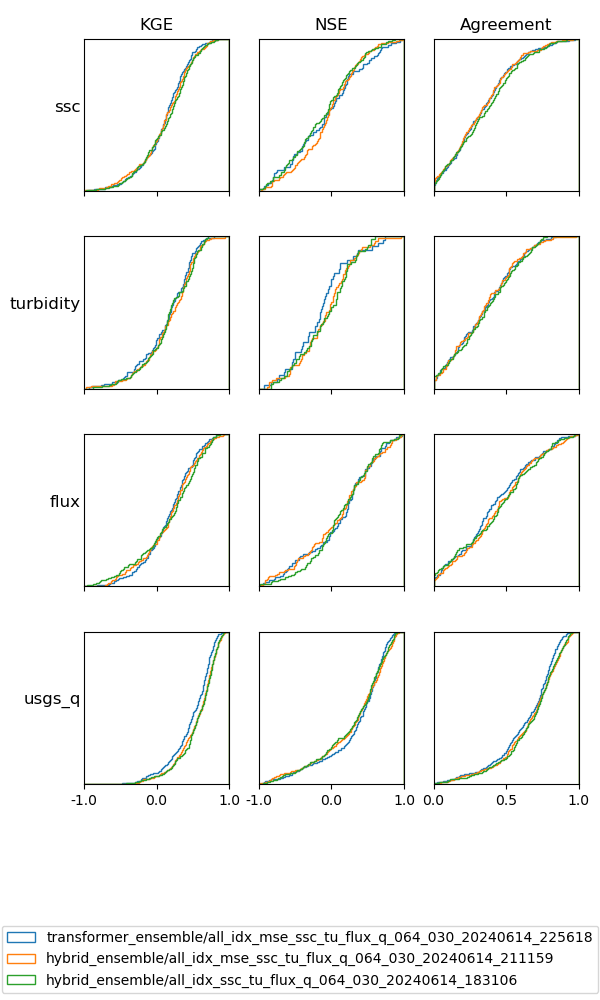

In [17]:
plt.close('all')

features = bulk_metrics[0].keys()

metric_args = {
    'KGE':{'range':[-1,1]},
    'NSE':{'range':[-1,1]},
    'Agreement':{'range':[0,1]}}
common_args = {
    'bins': 500,
    'cumulative': True, 
    'density': True,
    'histtype': 'step'}

nRows = len(features)+1 #Extra row for legend
nCols = len(metric_args)
fig, axes = plt.subplots(nRows, nCols, figsize=(2*nCols,2*nRows))

    
for feature, axes_row in zip(features, axes[:-1]):
    for (metric, metric_kwargs), ax in zip(metric_args.items(), axes_row):
        for m in basin_metrics:
            x = m[feature, metric].astype(float)
            x = x[np.isfinite(x)]
            ax.hist(x, **common_args, **metric_kwargs)
        
        ax.set_aspect(1./ax.get_data_ratio())
        ax.set_xlim(metric_kwargs['range'])
        ax.set_ylim([0,1])
        # ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        
for (metric, _), ax in zip(metric_args.items(), axes[0,:]):
    ax.set_title(metric)
    
for feature, ax in zip(features, axes[:-1,0]):
    ax.set_ylabel(feature, rotation=0, ha='right', fontsize='large', labelpad=2)

for ax in axes[-2,:]:
    ax.set_xticks(np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 3))
    ax.set_xticklabels(np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 3))

for ax in axes[-1,:]:
    ax.set_axis_off()
title_strs = [f"{Path(*d.parts[-2:])}" for d in exp_dirs]
fig.legend(title_strs, loc='lower center')

fig.tight_layout()

In [18]:
from train import load_last_state
from data import TAPDataset, TAPDataLoader
from evaluate import predict

# basin = 'USGS-09367540'
# basin = 'USGS-06109500' #no flux but nice seasonality
basin = 'USGS-08332010' #Nice flux temporal distribution and seasonality


exp_preds = []
for exp_dir in exp_dirs:
    cfg, model, trainer_state, opt_state, _ = load_last_state(exp_dir)
    cfg['quiet'] = False
    cfg['data_subset'] = 'predict'
    cfg['basin_subset'] =  basin
    cfg['num_workers'] = 0 # Faster for small runs
    
    dataset = TAPDataset(cfg)
    dataloader = TAPDataLoader(cfg, dataset)
    preds = predict(model, dataloader, seed=0, denormalize=True, return_dt=True)
    preds['pred'] = preds['pred'] * (preds['pred']>0) #Clip preds to 0

    preds = preds.reset_index()
    preds = preds.sort_values(by='date')
    preds = preds.drop('basin', axis=1, level=0)
    preds.set_index('date', inplace=True)
    
    exp_preds.append(preds)

Loading model state from ../runs/transformer_ensemble/all_idx_mse_ssc_tu_flux_q_064_030_20240614_225618/epoch086


CUDA backend failed to initialize: INTERNAL: no supported devices found for platform CUDA (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Dropping static attributes with 0 variance: ['glc_pc_s03', 'glc_pc_s05', 'glc_pc_s07', 'glc_pc_s08', 'glc_pc_s17', 'glc_pc_s19', 'pnv_pc_s03', 'wet_pc_s05', 'wet_pc_s06', 'wet_pc_s07']
Using cached basin dataset file.
Dataloader using 0 parallel CPU worker(s).
Batch sharding set to 1 cpu(s)


  0%|          | 0/51 [00:00<?, ?it/s]

Loading model state from ../runs/hybrid_ensemble/all_idx_mse_ssc_tu_flux_q_064_030_20240614_211159/epoch100
Dropping static attributes with 0 variance: ['glc_pc_s03', 'glc_pc_s05', 'glc_pc_s07', 'glc_pc_s08', 'glc_pc_s17', 'glc_pc_s19', 'pnv_pc_s03', 'wet_pc_s05', 'wet_pc_s06', 'wet_pc_s07']
Using cached basin dataset file.
Dataloader using 0 parallel CPU worker(s).
Batch sharding set to 1 cpu(s)


  0%|          | 0/51 [00:00<?, ?it/s]

Loading model state from ../runs/hybrid_ensemble/all_idx_ssc_tu_flux_q_064_030_20240614_183106/epoch100
Dropping static attributes with 0 variance: ['glc_pc_s03', 'glc_pc_s05', 'glc_pc_s07', 'glc_pc_s08', 'glc_pc_s17', 'glc_pc_s19', 'pnv_pc_s03', 'wet_pc_s05', 'wet_pc_s06', 'wet_pc_s07']
Using cached basin dataset file.
Dataloader using 0 parallel CPU worker(s).
Batch sharding set to 1 cpu(s)


  0%|          | 0/51 [00:00<?, ?it/s]

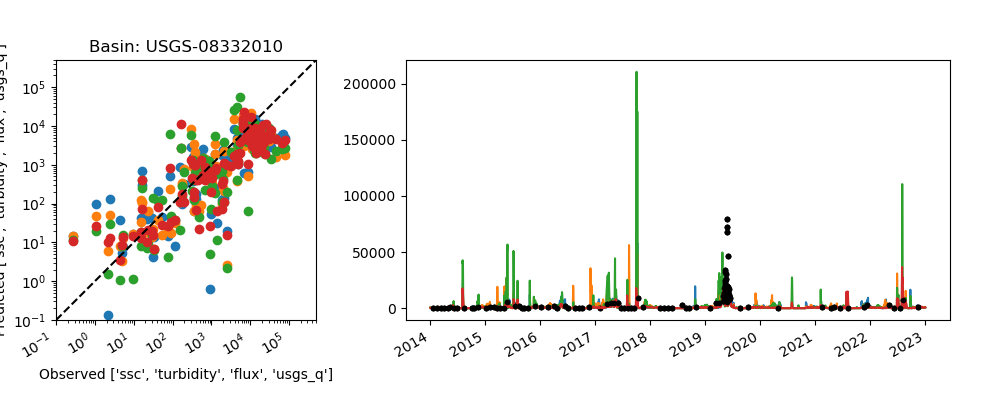

In [203]:
import matplotlib.gridspec as gridspec

# Plot the true values and predictions
plt.close('all')

# Create a figure
fig = plt.figure(figsize=(10, 4))

# Create a GridSpec with 1 row and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0.2, 2])
axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 2])]


min_val = 1E-1
max_val = 5E5

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for preds, color in zip(exp_preds, colors):
    pred = preds['pred']['flux']
    obs = preds['obs']['flux']
    axes[0].scatter(obs, pred, color=color)

    axes[1].plot(pred, color=color)
    axes[1].plot(obs, linestyle='None',marker='.',color='k')

axes[0].plot([min_val, max_val], [min_val, max_val], 'k--')

# Setting axes to be square and equal range
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].axis('square')
axes[0].set_xlim(min_val, max_val)
axes[0].set_ylim(min_val, max_val)
axes[0].set_xlabel(f"Observed {cfg['features']['target']}")
axes[0].set_ylabel(f"Predicted {cfg['features']['target']}")
axes[0].set_title(f"Basin: {basin}")

# axes[1].set_ylim([0,40000])


fig.subplots_adjust(top=0.85, left=0.05, right=0.95, wspace=0.05, hspace=0.4)
# fig.suptitle(str(run_dir))
fig.autofmt_xdate()

plt.show()

# fig.savefig(run_dir / f"{basin}_timeseries.png",  dpi=300)

In [201]:


colors

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']